In [1]:
import numpy as np
import gym
import torch

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

# this way of importing allow to reload/refresh the module later with importlib.reload(policy)
import policy as policy 
import memory as mem
from feedforward import Feedforward
from custompendulumenv import CustomPendulumEnv

# Added for nicer logging
from tqdm import tqdm

Load environment, policy and memory.

In [2]:
env = gym.make('CustomPendulum-v0')
pi = policy.PDPolicy(env)
buffer = mem.Memory()

## Inspect the environment 

In [3]:
s = env.reset()
for t in range(100):
    env.render()
    a = pi.get_action(s) 
    s_new, rew, done, _ = env.step(a)
    buffer.add_transition([s,a,rew,s_new, done])
    s = s_new

In [4]:
transitions = buffer.get_all_transitions()
states = np.vstack(transitions[:,0])
actions = transitions[:,1]
rewards = transitions[:,2]

Plot the trajectory: (state, action, reward)
 
 The state is [position, velocity] 
 
 **changes are needed**

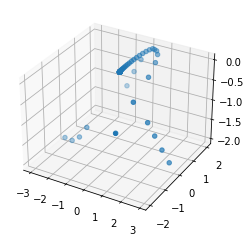

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=states[:, 0],
        ys=actions,
        zs=rewards)
plt.show()

# Collect data

We do 500 rollouts a 100 timesteps with the black box policy. Nothing needs to be changed here.

In [6]:
for ep in range(500):
    s = env.reset()
    for t in range(100):
        a = pi.get_action(s) 
        s_new, rew, done, _ = env.step(a)
        buffer.add_transition([s,a,rew,s_new, done])
        s = s_new

In [7]:
buffer.size

50100

# Fit value function

The value function fitting class. Here, you need to fill in the blank parts

In [8]:
class ValueFunction(Feedforward):
    def __init__(self, observation_dim, device, hidden_sizes=[100,100]):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, output_size=1, device=device)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, eps=0.000001)
        
        self.loss = torch.nn.MSELoss()
    
    def fit(self, observations, targets):
        # Add one training step here. 
        # The states are called here observations        
        self.optimizer.zero_grad()

        targets = targets.to(self.device)

        t_observations = torch.FloatTensor(observations).to(self.device)
        preds = self.forward(t_observations)

        loss = self.loss(preds, targets)

        loss.backward()
        self.optimizer.step()        

        # return the current loss
        return loss.item()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

In [10]:
valuefunc = ValueFunction(observation_dim=2, device=device)
if device.type == 'cuda':
    valuefunc.cuda()

In [11]:
def plot_values(valuefunc, filename):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi,np.pi)
    yys =np.linspace(-8,8)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([XX.ravel(),YY.ravel()]).T
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values = valuefunc.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=[10,8])
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    fig.savefig(filename, bbox_inches="tight")

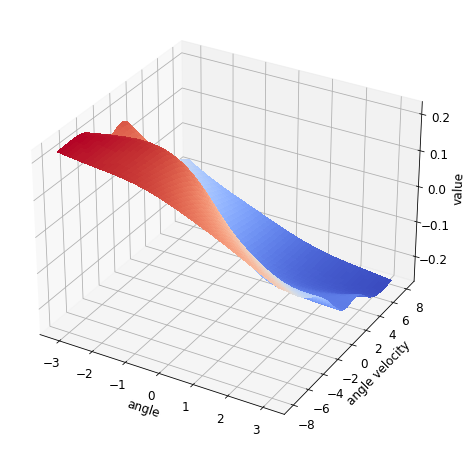

In [12]:
plot_values(valuefunc, 'before_training.pdf')

Fitting routine of the value function. Fill in the blank parts.

100%|██████████| 30000/30000 [07:53<00:00, 63.31it/s]


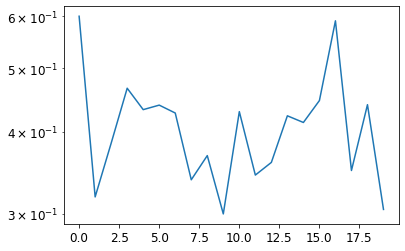

In [13]:
plt_fit = []
iter_fit = 30000 # do at least 1000 
gamma=0.95
for i, _ in enumerate(tqdm(range(iter_fit))):

    # sample from the replay buffer
    data=buffer.sample(batch=128)
    # each entry in data is (state,action,reward,next_state, done)    

    states = np.stack(data[:, 0])
    
    next_states = torch.FloatTensor(np.stack(data[:, -2]))
    next_state_values = valuefunc.forward(next_states)
    
    rewards = torch.FloatTensor(np.stack(data[:, 2])).to(device)
    td_target = rewards + gamma * next_state_values
            
    # optimize the least squared objective
    fit_loss = valuefunc.fit(states, td_target)
    
    if i % (iter_fit / 20) == 0:
        print(f'\t\tLoss:\t{fit_loss:.4f}')
        plt_fit.append(fit_loss)
    
# plot the loss
plt.figure()
plt.yscale("log")
plt.plot(range(len(plt_fit)),plt_fit)

# Visualize

Visualization of the value function. Nothing needs to be changed here.

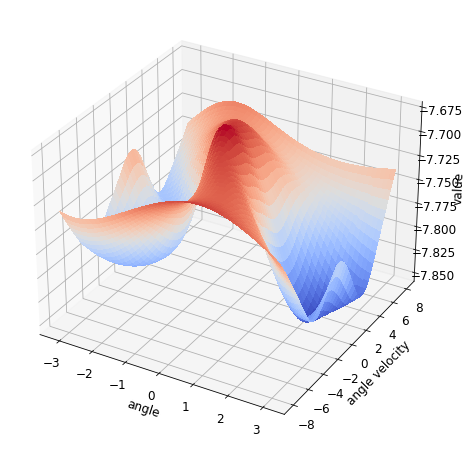

In [14]:
plot_values(valuefunc, f'value_approx_{gamma}.pdf')